In [33]:
#-----------------------------------
# GLOBAL FEATURE EXTRACTION
#-----------------------------------
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import mahotas
import os
import cv2
import h5py

#--------------------
# tunable-parameters
#--------------------
images_per_class       = 800
fixed_size             = tuple((500, 500))
train_path             = "dataset/train"
h5_train_data          = 'output/train_data.h5'
h5_train_labels        = 'output/train_labels.h5'
bins                   = 8


In [34]:
# Converting each image to RGB from BGR format

def rgb_bgr(image):
    rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return rgb_img


In [35]:
# Conversion to HSV image format from RGB

def bgr_hsv(rgb_img):
    hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
    return hsv_img

In [36]:
# image segmentation

# for extraction of green and brown color


def img_segmentation(rgb_img,hsv_img):
    lower_green = np.array([25,0,20])
    upper_green = np.array([100,255,255])
    healthy_mask = cv2.inRange(hsv_img, lower_green, upper_green)
    result = cv2.bitwise_and(rgb_img,rgb_img, mask=healthy_mask)
    lower_brown = np.array([10,0,10])
    upper_brown = np.array([30,255,255])
    disease_mask = cv2.inRange(hsv_img, lower_brown, upper_brown)
    disease_result = cv2.bitwise_and(rgb_img, rgb_img, mask=disease_mask)
    final_mask = healthy_mask + disease_mask
    final_result = cv2.bitwise_and(rgb_img, rgb_img, mask=final_mask)
    return final_result


In [37]:
# feature-descriptor-1: Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

In [38]:
# feature-descriptor-2: Haralick Texture
def fd_haralick(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick

In [39]:
# feature-descriptor-3: Color Histogram
def fd_histogram(image, mask=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

In [40]:
# get the training labels
import os
train_labels = os.listdir("C:/Users/shres/OneDrive/Documents/train")

# sort the training labels
train_labels.sort()
print(train_labels)

# empty lists to hold feature vectors and labels
global_features = []
labels          = []

['diseased', 'healthy']


is jagah mai bag of visula words ka use hoga for local features and global features presentation 

In [41]:
# loop over the training data sub-folders
for training_name in train_labels:
    # join the training data path and each species training folder
    dir = os.path.join("C:/Users/shres/OneDrive/Documents/train", training_name)

    # get the current training label
    current_label = training_name

    # loop over the images in each sub-folder
    for x in range(1,images_per_class+1):
        # get the image file name
        file = dir + "/" + str(x) + ".jpg"

        # read the image and resize it to a fixed-size
        image = cv2.imread(file)
        image = cv2.resize(image, fixed_size)

        
        # Running Function Bit By Bit
        
        RGB_BGR       = rgb_bgr(image)
        BGR_HSV       = bgr_hsv(RGB_BGR)
        IMG_SEGMENT   = img_segmentation(RGB_BGR,BGR_HSV)

        # Call for Global Fetaure Descriptors
        
        fv_hu_moments = fd_hu_moments(IMG_SEGMENT)
        fv_haralick   = fd_haralick(IMG_SEGMENT)
        fv_histogram  = fd_histogram(IMG_SEGMENT)
        
        # Concatenate 
        
        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
        
        

        # update the list of labels and feature vectors
        labels.append(current_label)
        global_features.append(global_feature)

    print("[STATUS] processed folder: {}".format(current_label))

print("[STATUS] completed Global Feature Extraction...")

[STATUS] processed folder: diseased
[STATUS] processed folder: healthy
[STATUS] completed Global Feature Extraction...


In [42]:
# print(global_features)

In [43]:
# get the overall feature vector size
print("[STATUS] feature vector size {}".format(np.array(global_features).shape))

[STATUS] feature vector size (1600, 532)


In [44]:
# get the overall training label size
print("[STATUS] training Labels {}".format(np.array(labels).shape))

[STATUS] training Labels (1600,)


In [45]:
# encode the target labels
targetNames = np.unique(labels)
le          = LabelEncoder()
target      = le.fit_transform(labels)
print("[STATUS] training labels encoded...")

[STATUS] training labels encoded...


In [46]:
# scale features in the range (0-1)
from sklearn.preprocessing import MinMaxScaler
scaler            = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
print("[STATUS] feature vector normalized...")

[STATUS] feature vector normalized...


In [47]:
print("[STATUS] target labels: {}".format(target))
print("[STATUS] target labels shape: {}".format(target.shape))

[STATUS] target labels: [0 0 0 ... 1 1 1]
[STATUS] target labels shape: (1600,)


In [48]:
# save the feature vector using HDF5
h5f_data = h5py.File(h5_train_data, 'w')
h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))

<HDF5 dataset "dataset_1": shape (1600, 532), type "<f8">

In [49]:
h5f_label = h5py.File(h5_train_labels, 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))

<HDF5 dataset "dataset_1": shape (1600,), type "<i8">

In [50]:
h5f_data.close()
h5f_label.close()

In [52]:
# training
#-----------------------------------
# TRAINING OUR MODEL
#-----------------------------------
import h5py
import numpy as np
import os
import glob
import cv2
import warnings
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


warnings.filterwarnings('ignore')

#--------------------
# tunable-parameters
#--------------------
num_trees = 100
test_size = 0.20
seed      = 9
train_path = "dataset/train"
test_path  = "dataset/test"
h5_train_data    = 'output/train_data.h5'
h5_train_labels  = 'output/train_labels.h5'
scoring    = "accuracy"

# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()

if not os.path.exists(test_path):
    os.makedirs(test_path)

# create all the machine learning models
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=seed)))

# variables to hold the results and names
results = []
names   = []

# import the feature vector and trained labels
h5f_data  = h5py.File(h5_train_data, 'r')
h5f_label = h5py.File(h5_train_labels, 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string   = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels   = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

# verify the shape of the feature vector and labels
print("[STATUS] features shape: {}".format(global_features.shape))
print("[STATUS] labels shape: {}".format(global_labels.shape))

print("[STATUS] training started...")


[STATUS] features shape: (1600, 532)
[STATUS] labels shape: (1600,)
[STATUS] training started...


In [53]:
# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape)) 

[STATUS] splitted train and test data...
Train data  : (1280, 532)
Test data   : (320, 532)


In [54]:
trainDataGlobal

array([[0.97973956, 0.        , 0.        , ..., 0.01058888, 0.12693628,
        0.96573219],
       [0.90470961, 0.03308547, 0.03047729, ..., 0.01058886, 0.12692807,
        0.96573214],
       [0.92166131, 0.01766604, 0.03559807, ..., 0.01058994, 0.12737134,
        0.96573262],
       ...,
       [0.77039234, 0.        , 0.        , ..., 0.01058886, 0.12693296,
        0.96573218],
       [0.96965597, 0.        , 0.        , ..., 0.01058989, 0.1271198 ,
        0.96574232],
       [0.98389776, 0.19183335, 0.15462199, ..., 0.01058898, 0.12695993,
        0.96573136]])

LR: 0.916406 (0.021833)
LDA: 0.907813 (0.019702)
KNN: 0.920312 (0.012500)
CART: 0.906250 (0.027951)
RF: 0.957031 (0.013189)
NB: 0.857031 (0.010511)
SVM: 0.916406 (0.020086)


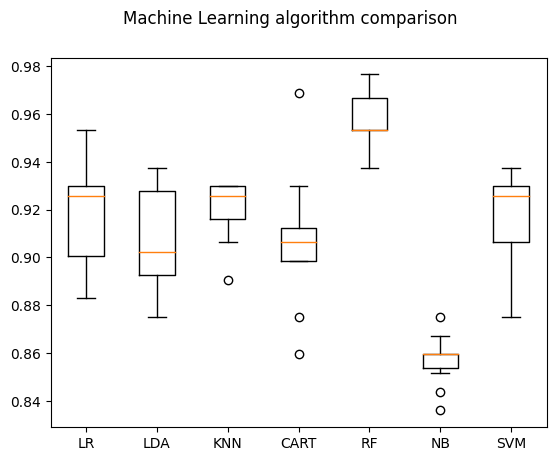

In [59]:
# 10-fold cross validation
for name, model in models:
    kfold = KFold(n_splits=10,shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [60]:
clf  = RandomForestClassifier(n_estimators=num_trees, random_state=seed)

In [61]:
clf.fit(trainDataGlobal, trainLabelsGlobal)


RandomForestClassifier(random_state=9)

In [62]:
y_predict=clf.predict(testDataGlobal)

In [63]:
y_predict

array([1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,

In [64]:
cm = confusion_matrix(testLabelsGlobal,y_predict)

<AxesSubplot: >

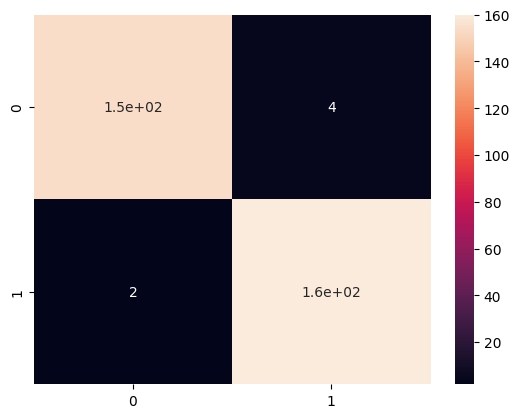

In [66]:
import seaborn as sns
sns.heatmap(cm ,annot=True)

In [67]:
print(classification_report(testLabelsGlobal,y_predict))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       158
           1       0.98      0.99      0.98       162

    accuracy                           0.98       320
   macro avg       0.98      0.98      0.98       320
weighted avg       0.98      0.98      0.98       320



In [68]:
from sklearn.metrics import accuracy_score

In [69]:
accuracy_score(testLabelsGlobal, y_predict)

0.98125